# Calculate sentence embeddings for generated JSON files

In [1]:
import os
import json

In [2]:
# Loads definitions from words.json
def load_definitions():
    with open("words.json") as f:
        return json.load(f)

definitions = load_definitions()

In [3]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(sentences)
print(len(embeddings))

/Users/esteban/src/llm-definition-modeling/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2


In [4]:
def extract_words(elements):
    return [element[0] for element in elements]

def extract_definitions(elements):
    return [element[1] for element in elements]

def prepare_bulk_embeddings(kv_word_definition):
    elements = [(word, definition) for word, definition in  kv_word_definition.items()]
    embeddings = model.encode(extract_definitions(elements))
    return {word: embedding for word, embedding in zip(extract_words(elements), embeddings)}

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm

definition_embeddings = prepare_bulk_embeddings({word : info["definition"] for word, info in definitions.items()})

In [6]:
from pathlib import Path
from numpy.linalg import norm


data = []

def cosine_similarity(a, b):
    return np.dot(a,b)/(norm(a) * norm(b))

for file in Path('./').glob('definitions-*.json'):
    # The files follow the pattern definitions-text-davinci-003.json,
    # where the model name is after definitions.
    filename = os.path.basename(file)
    model_name = filename.removeprefix("definitions-").removesuffix('.json').removeprefix("text-").removeprefix("google-").replace("-", " ").removesuffix(" 001").removesuffix(" 003")
    print(model_name)
    generated_definitions = {}
    with open(file, "r") as f:
        generated_definitions = json.load(f)
    embeddings_for_generated_definitions = prepare_bulk_embeddings(generated_definitions)
    for word, info in sorted(definition_embeddings.items()):
        word_expected_embedding = info
        word_calculated_definition = embeddings_for_generated_definitions[word]
        data.append((model_name, word, word_expected_embedding, word_calculated_definition, cosine_similarity(word_expected_embedding, word_calculated_definition)))

davinci
flan t5 small
gpt 3.5 turbo
flan t5 base
flan t5 xxl
curie
babbage
ada


In [7]:
df = pd.DataFrame(data, columns=["Model", "Word", "Expected Embedding", "Embedding", "Cosine Similarity"])
# Save results as CSV
df.to_csv("results.csv")

In [8]:
df

,Model,Word,Expected Embedding,Embedding,Cosine Similarity
0,davinci,binche,"[-0.15452431, 0.27044216, -0.19426286, 0.26514...","[-0.14295664, 0.34583807, 0.17155163, -0.08452...",0.290768
1,davinci,cacaratear,"[0.5979352, 0.22816516, -0.0039186045, 0.12172...","[0.43317002, -0.07921113, -0.024205763, 0.0673...",0.659316
2,davinci,descuachipilingar,"[0.24267441, -0.1300451, 0.22421287, 0.0775568...","[0.23874533, 0.013550104, -0.0026532833, -0.11...",0.571661
3,davinci,erquilipio,"[0.3033415, 0.054460667, 0.03789501, 0.2238274...","[0.20688297, 0.034634903, -0.15985419, 0.08150...",0.586918
4,davinci,giliwiro,"[-0.06002075, -0.045950763, -0.051009495, -0.4...","[-0.01678249, -0.30264214, 0.018964225, -0.126...",0.681416
...,...,...,...,...,...
155,ada,trapotar,"[0.069271065, 0.24051368, 0.02984015, 0.212878...","[-0.27394325, 0.03455324, 0.011075246, -0.0670...",0.463134
156,ada,watismajo,"[0.117882155, 0.0005040484, 0.14231655, -0.091...","[0.046944547, 0.28829923, -0.0778618, 0.030647...",0.197727
157,ada,wiwilar,"[0.14444937, 0.10060531, -0.0006900367, -0.053...","[-0.027765356, 0.25029922, 0.1386039, 0.092052...",0.126623
158,ada,yigate,"[0.20912664, 0.054997403, 0.06223139, 0.127039...","[0.15298462, 0.044890687, 0.23946084, -0.03841...",0.292225


In [9]:
df.groupby("Model").describe()

Cosine Similarity                                           
                          count      mean       std       min       25%   
Model                                                                     
ada                        20.0  0.194017  0.167661  0.007716  0.050672  \
babbage                    20.0  0.287637  0.141543  0.086875  0.197353   
curie                      20.0  0.358483  0.138913  0.062035  0.274068   
davinci                    20.0  0.518971  0.120155  0.290768  0.434792   
flan t5 base               20.0  0.271213  0.191695  0.058195  0.126296   
flan t5 small              20.0  0.232679  0.178587 -0.025473  0.100365   
flan t5 xxl                20.0  0.451821  0.191723 -0.027339  0.334376   
gpt 3.5 turbo              20.0  0.463009  0.144093  0.130273  0.377529   

                                             
                    50%       75%       max  
Model                                        
ada            0.173801  0.238698  0.672973  
babbage        0.254519  0.412992  0.622189  
curie          0.392626  0.457206  0.546517  
davinci        0.519590  0.601297  0.732204  
flan t5 base   0.193537  0.382619  0.627252  
flan t5 small  0.202903  0.265144  0.630888  
flan t5 xxl    0.441543  0.578598  0.760450  
gpt 3.5 turbo  0.485864  0.580770  0.693497

<Axes: xlabel='Cosine Similarity', ylabel='Count'>

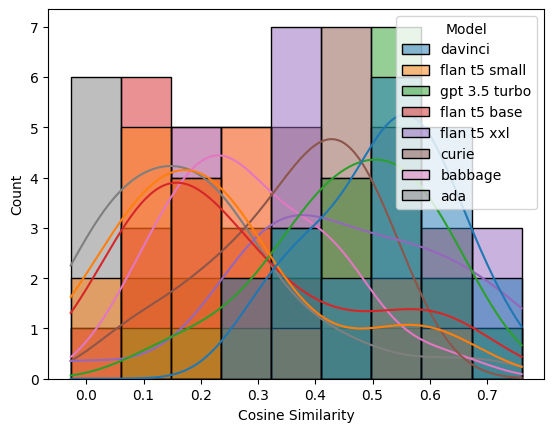

In [10]:
import seaborn as sns

sns.histplot(data=df, x="Cosine Similarity", hue="Model", kde=True)


<Axes: xlabel='Cosine Similarity', ylabel='Density'>

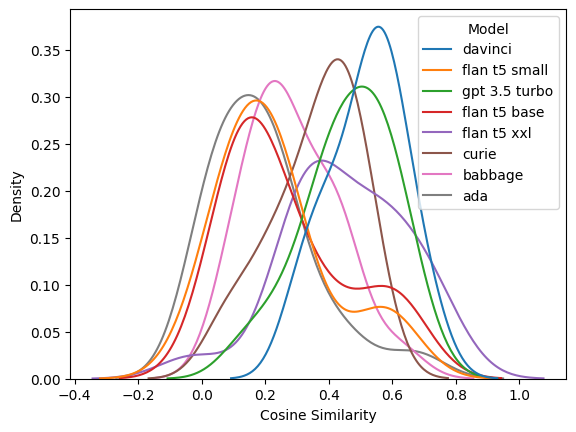

In [11]:
sns.kdeplot(data=df, x="Cosine Similarity", hue="Model")


<Axes: xlabel='Cosine Similarity', ylabel='Model'>

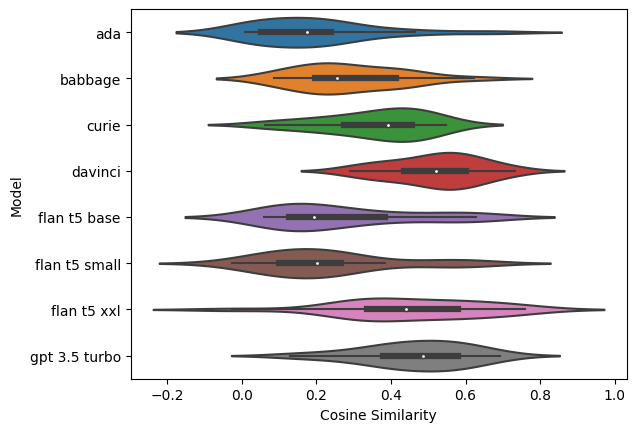

In [12]:
plot_order = sorted(set(df.Model.values))
plot_order.remove("gpt 3.5 turbo")
plot_order.append("gpt 3.5 turbo")
sns.violinplot(data=df, x="Cosine Similarity", y="Model", order=plot_order)

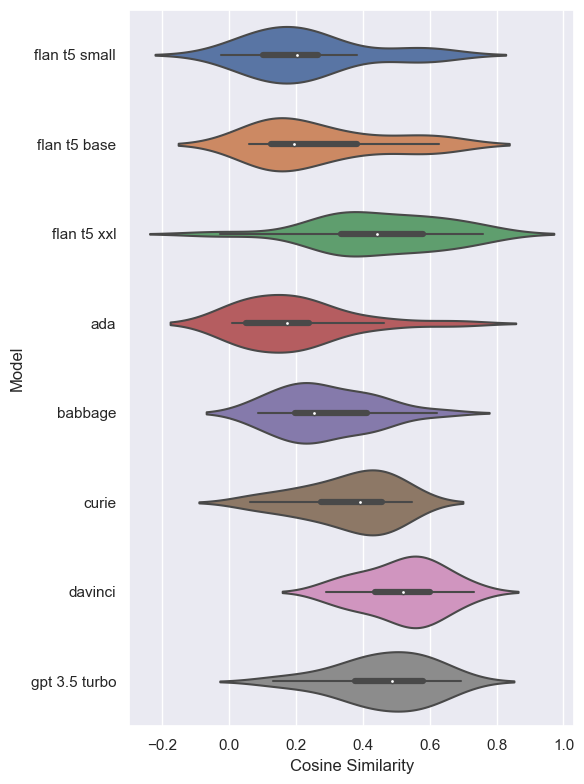

In [13]:
plot_order = [
    'flan t5 small',
    'flan t5 base',
 'flan t5 xxl',
 'ada',
 'babbage',
 'curie',
 'davinci',
 'gpt 3.5 turbo']
sns.set(rc={'figure.figsize':(6,8)})
sns.violinplot(data=df, x="Cosine Similarity", y="Model", order=plot_order)

# Save the plot as PDF
import matplotlib.pyplot as plt
plt.tight_layout()
plt.savefig("violinCanonical.pdf")

<Axes: xlabel='Cosine Similarity', ylabel='Density'>

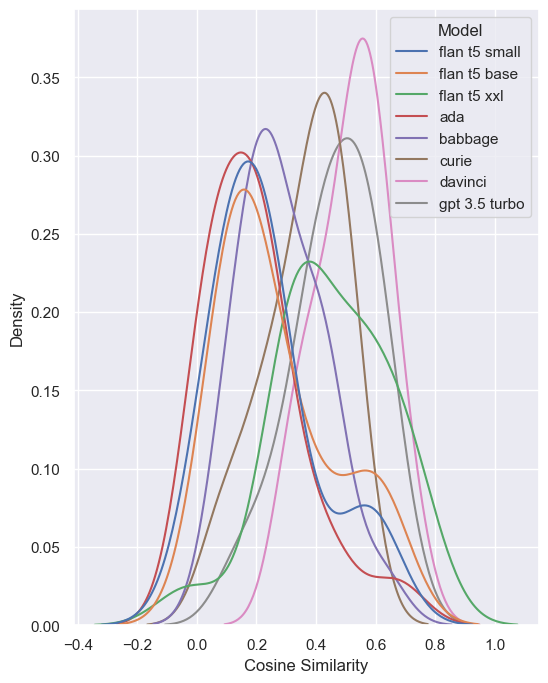

In [14]:
sns.kdeplot(data=df, x="Cosine Similarity", hue="Model", hue_order=plot_order)


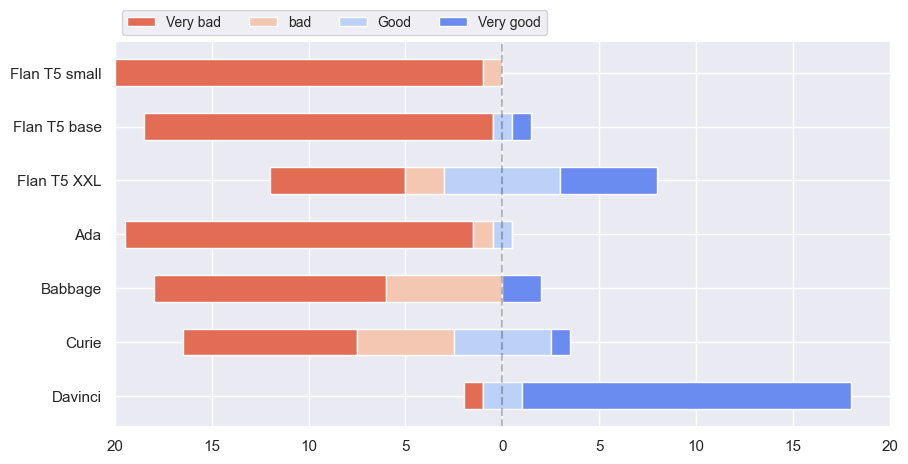

In [15]:
import numpy as np
import matplotlib.pyplot as plt


category_names = ['Very bad', 'bad',
                  'Good', 'Very good']
results = {
    'Flan T5 small': [19, 1, 0, 0],
    'Flan T5 base': [18, 0, 1, 1],
    'Flan T5 XXL': [7, 2, 6, 5],
    'Ada': [18, 1, 1, 0],
    'Babbage': [12, 6, 0, 2],
    'Curie': [9, 5, 5, 1],
    'Davinci': [1, 0, 2, 17],
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly aisagree'
    category_names : list of str
        The category labels.
    """
    
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1]//2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    ax.set_xlim(-20, 20)
    ax.set_xticks(np.arange(-20, 21, 5))
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Ledgend
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')

    return fig, ax


fig, ax = survey(results, category_names)
plt.show()

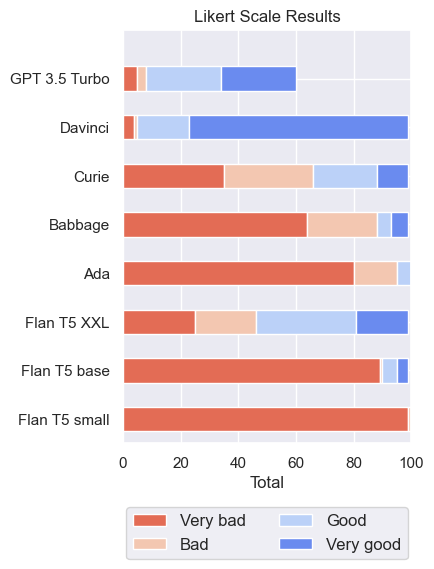

In [16]:
import matplotlib.pyplot as plt
import numpy as np

results_old = {
    'Flan T5 small': [39, 1, 0, 0],
    'Flan T5 base': [36, 0, 2, 2],
    'Flan T5 XXL': [12, 5, 11, 11],
    'Ada': [35, 2, 3, 0],
    'Babbage': [28, 6, 1, 4],
    'Curie': [18, 8, 8, 5],
    'Davinci': [2, 1, 4, 33],
    'GPT 3.5 Turbo': [5, 3, 26, 26],
}

category_names = ['Very bad', 'Bad', 'Good', 'Very good']
results = {
    'Flan T5 small': [99, 1, 0, 0],
    'Flan T5 base': [89, 1, 5, 4],
    'Flan T5 XXL': [25, 21, 35, 18],
    'Ada': [80, 15, 5, 0],
    'Babbage': [64, 24, 5, 6],
    'Curie': [35, 31, 22, 11],
    'Davinci': [4, 1, 18, 76],
    'GPT 3.5 Turbo': [5, 3, 26, 26],
}

# Convert the data to a numpy array
data = np.array([results[name] for name in results.keys()])

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(4.5, 6))

# Set the x and y axis limits
ax.set_xlim(0, np.sum(data, axis=1).max())
ax.set_ylim(-0.5, len(results))

# Set the y-axis labels
ax.set_yticks(np.arange(len(results)))
ax.set_yticklabels(results.keys())

# Set the x-axis labels
ax.set_xlabel('Total')

# Define the colors for the bars
colors = plt.get_cmap('coolwarm_r')(
        np.linspace(0.15, 0.85, 4))

# Create a stacked horizontal bar chart
for i in range(len(category_names)):
    ax.barh(np.arange(len(results)), data[:, i], left=np.sum(data[:, :i], axis=1), height=0.5, color=colors[i], label=category_names[i])

# Add a legend to the plot
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2, fontsize='medium')

# Add a title to the plot
ax.set_title('Likert Scale Results')

# Display the plot
plt.tight_layout()
plt.savefig("likert.pdf")